In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pylab as plt
from sent_art_analysis import full_processing as fp
from sent_art_analysis import normalize, plot_norm_outliers
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import statsmodels.api as sm


In [2]:
TC = Path('SentiArt-main/250kSentiArt_EN.xlsx') # for English texts
sa = pd.read_excel(TC) 


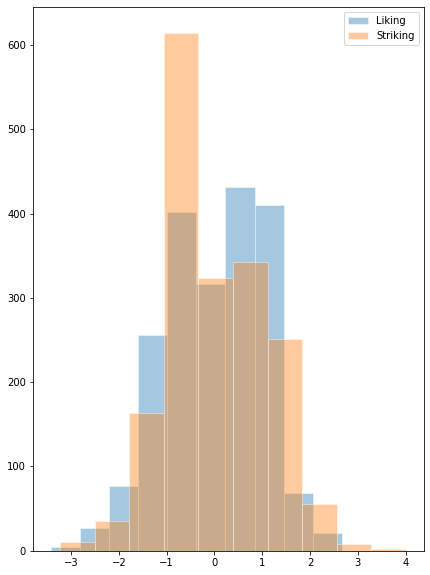

In [21]:
like_df = []
strike_df = []
n_w, n_set = [], []
for i in range(3):
    #reading csvs without zeros (zeros mean a person didn't get this song as a result of randomization error)
    df_liking = pd.read_csv(f"Liking_LBL_S{i+1}-D1.csv").iloc[:-1, 1:]
    df_liking = df_liking[(df_liking.T != 0).any()].reset_index(drop=True)
    
    #normalizing data
    df_liking = normalize(df_liking)
    #plot_norm_outliers(df_liking, i+1, "Liking", n_not_norm=3)
    
    df_striking = pd.read_csv(f"Striking_LBL_S{i+1}-D1.csv").iloc[:-1, 1:]
    # song 2 bug row 15 all ones
    df_striking = df_striking[(df_striking.T != 1).any()] #there was one participant who has 1s almost everywhere
    df_striking = df_striking[(df_striking.T != 0).any()].reset_index(drop=True) #deleting 0s 
    
    df_striking = normalize(df_striking)
    #plot_norm_outliers(df_striking, i+1, "Striking", n_not_norm=3)
    
    a, b = fp('all_songs_c.xlsx', i, sa, df_liking, df_striking)
    n_w.append(a)
    n_set.append(b)
    
    like_df.append(df_liking.to_numpy().flatten().tolist())
    strike_df.append(df_striking.to_numpy().flatten().tolist())

    
like_df = sum(like_df, [])
strike_df = sum(strike_df, [])


#plotting histograms of standartized liking and striking values
fig, ax = plt.subplots(figsize=(7, 10))

ax.hist(like_df, alpha=0.4, edgecolor='white', linewidth=1,  label='Liking') # bins=5,  density=True,
ax.hist(strike_df, alpha=0.4, edgecolor='white', linewidth=1, label='Striking') # bins=5, density=True, 

# plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.savefig('all_norm.png', dpi=200)
# plt.show()

In [22]:
i=0
bag_of_words, values_sentiart = fp('all_songs_c.xlsx', i, sa, df_liking, df_striking)

#hit ratio
values_sentiart.shape[0]/len(bag_of_words)

0.994475138121547

In [23]:
path_final = "/Users/willow/Desktop/group7data_inclmeans.xlsx"
final_results = pd.read_excel(path_final, sheet_name=1) 

In [174]:
s1 = pd.read_excel('/Users/willow/Desktop/WiSe2020/ASN/all_songs.xlsx', sheet_name = 0).loc[:, 'Line']
s2 = pd.read_excel('/Users/willow/Desktop/WiSe2020/ASN/all_songs.xlsx', sheet_name = 1).loc[:, 'Line']
s3 = pd.read_excel('/Users/willow/Desktop/WiSe2020/ASN/all_songs.xlsx', sheet_name = 2).loc[:, 'Line']
songs_with_cont = [s1, s2, s3]
analyser = SentimentIntensityAnalyzer()

dfs = []
n_lines = 0

liking_ludi = []
striking_ludi = []

for i in range(3): #[0]
    
    df_liking = pd.read_csv(f"Liking_LBL_S{i+1}-D1.csv").iloc[:-1, 1:]
    liking_ludi.append(df_liking.to_numpy().mean(axis=1))
    df_liking = df_liking[(df_liking.T != 0).any()].reset_index(drop=True)
    
    df_liking = normalize(df_liking)
    # plot_norm_outliers(df_liking, i+1, "Liking", n_not_norm=3)
    
    
    df_striking = pd.read_csv(f"Striking_LBL_S{i+1}-D1.csv").iloc[:-1, 1:]
    striking_ludi.append(df_striking.to_numpy().mean(axis=1))
    # song 2 bug row 15 all ones
    df_striking = df_striking[(df_striking.T != 1).any()]
    df_striking = df_striking[(df_striking.T != 0).any()].reset_index(drop=True)
    
    df_striking = normalize(df_striking)
    # plot_norm_outliers(df_striking, i+1, "Striking", n_not_norm=3)
    
    
    
    tokens_raw, tokens, song_results = fp('all_songs_c.xlsx', i, sa, df_liking, df_striking, True)
    
    song_results[['AAPz']].round(2).to_csv(f'aapz_song_{i+1}.csv',index=False)
    compound_scores = []
    for i in songs_with_cont[i]:
        compound_scores.append(analyser.polarity_scores(i)['compound'])
    
    
    song_results.loc[:, 'vader'] = compound_scores
    song_results.loc[:, 'Liking'] = df_liking.to_numpy().mean(axis=0)
    song_results.loc[:, 'Striking'] = df_striking.to_numpy().mean(axis=0)
    
    beg, end = n_lines, len(song_results.loc[:, 'Striking']) + n_lines - 1 
    
    final_results.loc[beg:end, 'Liking_z'] = song_results.loc[:, 'Liking'].values
    final_results.loc[beg:end, 'Strikingness_z'] = song_results.loc[:, 'Striking'].values
    for i, (lines_raw, line) in enumerate(zip(tokens_raw, tokens)):
        final_results.loc[beg+i, 'Tokenized'] = ' '.join(lines_raw)
        final_results.loc[beg+i, 'Tokenized_content'] = ' '.join(line)
    
    n_lines += len(song_results.loc[:, 'Striking'])
    
    dfs.append(song_results)
full_results_df = pd.concat(dfs, ignore_index=True)

striking_ludi = np.vstack(striking_ludi).mean(axis=0)
liking_ludi = np.vstack(liking_ludi).mean(axis=0)

### Plots of AAP & Liking & Striking & Vader

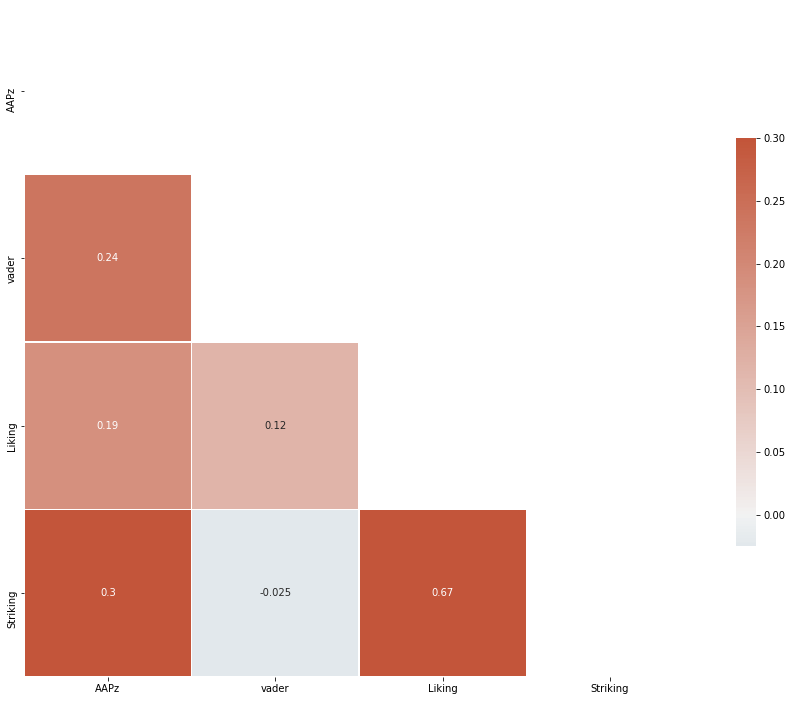

In [11]:
corr = full_results_df[['AAPz', 'vader', 'Liking', 'Striking']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.savefig(fname='corel_part_conten', dpi=200)

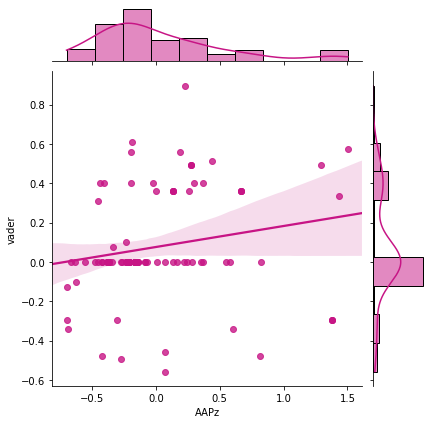

In [39]:
g1 = sns.jointplot(x="AAPz", y="vader", data=full_results_df,
                  kind="reg", truncate=False,
                  color="mediumvioletred")
plt.savefig(fname='vaderaap', dpi=200)

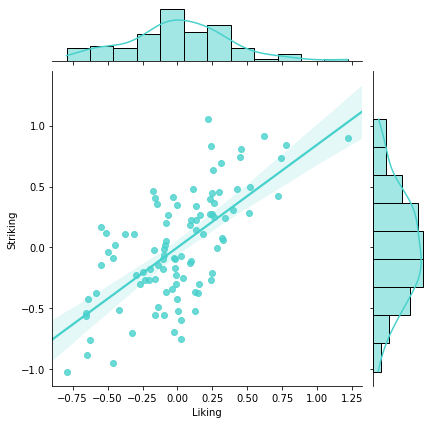

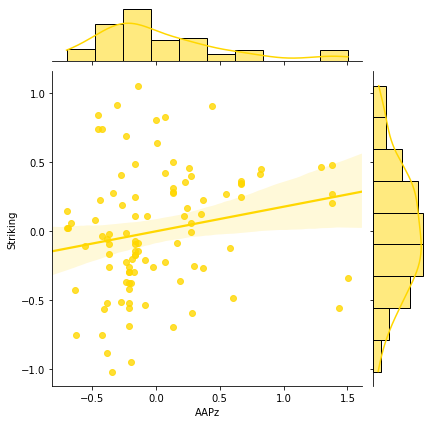

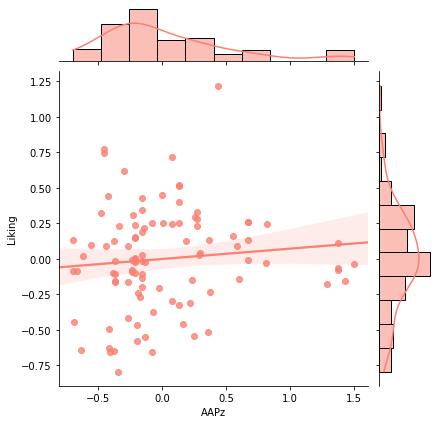

In [40]:
g1 = sns.jointplot(x="Liking", y="Striking", data=full_results_df,
                  kind="reg", truncate=False,
                  color="mediumturquoise")
plt.savefig('Liking_Striking.png', dpi=200)

g2 = sns.jointplot(x='AAPz', y="Striking", data=full_results_df,
                  kind="reg", truncate=False,
                  color="gold")
plt.savefig('AAP_Striking.png', dpi=200)

g3 = sns.jointplot(x="AAPz", y='Liking', data=full_results_df,
                  kind="reg", truncate=False,
                  color="salmon")

plt.savefig('AAP_Liking.png', dpi=200)

### Stats AAP & Liking & Striking & Vader

In [16]:
scipy.stats.pearsonr(full_results_df['AAPz'], full_results_df['vader'])

(0.23658350267405945, 0.018390800043687528)

In [19]:
mod = sm.OLS(full_results_df['Liking'], full_results_df['AAPz'])

In [20]:
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Liking   R-squared (uncentered):                   0.033
Model:                            OLS   Adj. R-squared (uncentered):              0.023
Method:                 Least Squares   F-statistic:                              3.324
Date:                Thu, 18 Feb 2021   Prob (F-statistic):                      0.0713
Time:                        14:02:55   Log-Likelihood:                         -35.300
No. Observations:                  99   AIC:                                      72.60
Df Residuals:                      98   BIC:                                      75.20
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### data frame for final stats

In [92]:
#average song liking from existing data
songs_liking = full_results_df.loc[:,"Liking"]
song1_liking = full_results_df.loc[:58,"Liking"]
song2_liking = full_results_df.loc[59:74,"Liking"]
song3_liking = full_results_df.loc[75:,"Liking"]

#average song striking
songs_striking = full_results_df.loc[:,"Striking"]
song1_striking = full_results_df.loc[:58,"Striking"]
song2_striking = full_results_df.loc[59:74,"Striking"]
song3_striking = full_results_df.loc[75:,"Striking"]

In [213]:
#reading new data frame containing full resuls
df2 = pd.read_excel('/Users/willow/Desktop/WiSe2020/ASN/group7data.xlsx')

In [321]:
# liking_overall, liking, striking

df2.loc[df2['QUESTNNR']=='Striking', 
             'Strikingness'] = striking_ludi[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18]]
df2.loc[df2['QUESTNNR']=='Liking', 'Liking'] = liking_ludi


cols = ['SR01_07', 'SR02_07', 'SR03_07', 'LS01_01', 'LS02_01', 'LS03_01', 'SS01_01', 'SS02_01','SS03_01',
       'openness',
 'neurotic',
 'conscient',
 'agreeable',
 'extraversion',
 'reflect_complex',
 'intense_rebel',
 'upbeat_convent',
 'energ_rhythm',
 'famil_bd_trial',
 'famil_lyr_across_songs',
 'famil_song_across_songs',
 'proc_fluency',
 'overall liking', 'Strikingness', 'Liking']
all_vars = df2.loc[:37, cols]
all_vars.fillna(all_vars.mean(), inplace=True)
all_vars = normalize(all_vars.T)
all_vars = all_vars.T


all_vars.columns = cols
all_vars.loc[:,'native'] = df2['native']
all_vars.loc[:,'QUESTNNR'] = df2.loc[:,'QUESTNNR']
all_vars.loc[:,'Striking overall'] = all_vars.loc[:,['SS01_01', 'SS02_01','SS03_01']].mean(axis=1)
all_vars.loc[:,'Liking overall'] = all_vars.loc[:,['LS01_01', 'LS02_01','LS03_01']].mean(axis=1)

cols.append('Liking overall')
cols.append('Striking overall')

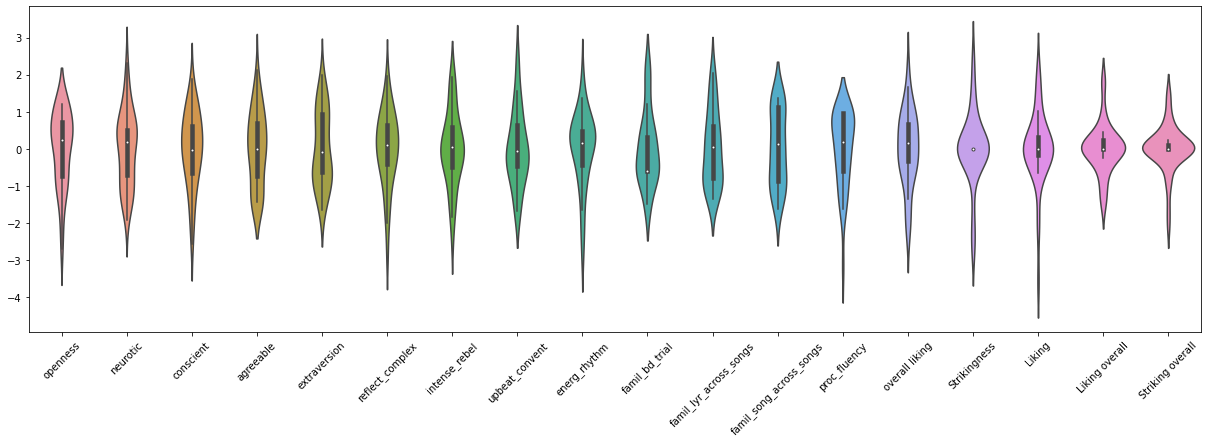

In [322]:
f, ax = plt.subplots(figsize=(21, 6))
vio = sns.violinplot(data=all_vars.loc[:, cols].iloc[:, 9:])
plt.xticks(rotation=45)
plt.show()

### Stats hypotheses

In [144]:
scipy.stats.pearsonr(all_vars['SR01_07'], all_vars['SS01_01'])

(-0.10397294344005092, 0.5344620100031237)

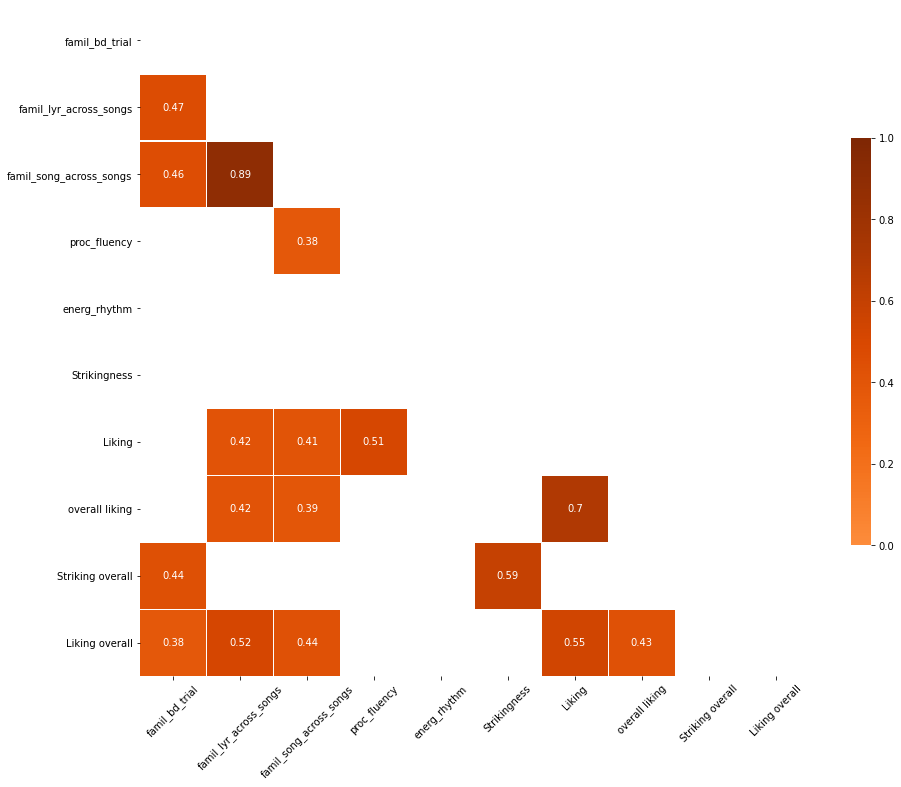

In [281]:
cols_for_corr = ['famil_bd_trial',
 'famil_lyr_across_songs',
 'famil_song_across_songs',
 'proc_fluency',
 'energ_rhythm','Strikingness', 'Liking',
 'overall liking', 'Striking overall', 'Liking overall']
corr = all_vars[cols_for_corr].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

for i, val1 in enumerate(cols_for_corr):
    for ii, val2 in enumerate(cols_for_corr):
        t, p = scipy.stats.pearsonr(all_vars[val1], all_vars[val2])
        if p > 0.05:
            mask[i, ii] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Oranges',vmin=0,  vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.xticks(rotation=45)
plt.savefig(fname='correl_hyp3', dpi=300)

In [361]:
df_ll = all_vars.loc[all_vars["QUESTNNR"]=='Liking', :]
mod = sm.OLS(df_ll['Liking overall'], df_ll[['Liking']])

In [362]:
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:         Liking overall   R-squared (uncentered):                   0.297
Model:                            OLS   Adj. R-squared (uncentered):              0.262
Method:                 Least Squares   F-statistic:                              8.458
Date:                Thu, 18 Feb 2021   Prob (F-statistic):                     0.00869
Time:                        22:20:21   Log-Likelihood:                         -23.757
No. Observations:                  21   AIC:                                      49.51
Df Residuals:                      20   BIC:                                      50.56
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

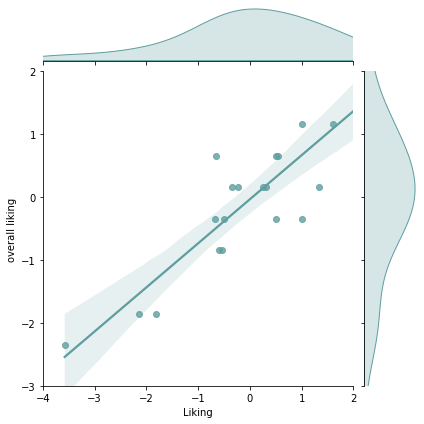

In [360]:

#plt.savefig('Liking_famil.png', dpi=200)
df_ll = all_vars.loc[all_vars["QUESTNNR"]=='Liking', :]
g = sns.JointGrid(data=df_ll, x="Liking", y="overall liking", xlim=[-4, 2], ylim=[-3, 2])
g.plot_joint(sns.regplot, color="cadetblue")
g.plot_marginals(sns.kdeplot, color="cadetblue", fill=True)

plt.savefig('Liking_famil.png', dpi=200)